In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [3]:
arch = Darknet([1,2,4,4,4], 28, 32, se=True); arch
# arch = wrn_22_10()

Darknet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): ResLayerSE(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [5]:
fname = train_names[0]

In [6]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 13.2 ms, sys: 4.21 ms, total: 17.4 ms
Wall time: 17 ms


In [7]:
im.shape

torch.Size([4, 512, 512])

In [8]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [9]:
from fastai.data_block import _extract_input_labels
fnames, labels = _extract_input_labels(seg, label_delim=' ')
test_fnames, _ = _extract_input_labels(sample_sub)

In [10]:
classes = uniqueify(np.concatenate(labels))

In [11]:
stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704,0.10145, 0.15313, 0.13814])
norm,denorm = normalize_funcs(*stats)

In [12]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=25, max_lighting=0.1, max_zoom=1.4, max_warp=0.4)

In [13]:
def get_data(sz=64, bs=64, is_test=False, pct = 0.1):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
    
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)



def get_data_custom(sz=64, bs=128, pct = 0.1, sample=10000):
    '''Custom Data Loader with weighted random sampler.
    sample = None (whole dataset)'''
    folder=TRAIN
    t_names = [TEST/f for f in test_names]
    test_labels = [[classes[0]]] * len(test_names)
    test_ds = Image4C_ds(t_names, test_labels, classes)
    train_ds, val_ds = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)

    datasets = [train_ds,val_ds, test_ds]
    datasets = transform_datasets(*datasets, tfms=tfms, size=sz)
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl, val_dl, test_dl, tfms=norm)


In [15]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [16]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
    learn.split((arch.layers[11],arch.layers[20]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 64

In [25]:
data = get_data_custom(64, 200, 0.1)
learn = get_learner(data, focal=False, fp16=True)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


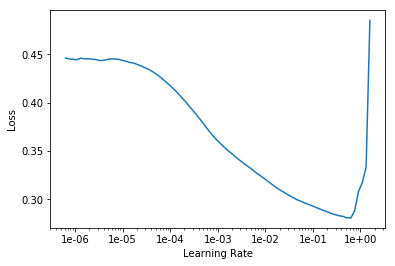

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr=1e-2

In [28]:
%time learn.fit_one_cycle(40, lr, wd=0.3, div_factor=10, pct_start=0.5)

Total time: 25:46
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.220755    0.191774    0.940862         0.049606  (00:39)
2      0.211131    0.198706    0.943511         0.011867  (00:38)
3      0.207095    0.178012    0.945024         0.036566  (00:38)
4      0.205133    0.180228    0.944405         0.052459  (00:38)
5      0.202792    0.179660    0.944646         0.047818  (00:38)
6      0.201211    0.172737    0.947237         0.049586  (00:38)
7      0.198098    0.172272    0.946515         0.052272  (00:38)
8      0.196183    0.172004    0.946583         0.057760  (00:38)
9      0.192853    0.174739    0.941722         0.052071  (00:38)
10     0.190256    0.163124    0.948211         0.077923  (00:38)
11     0.188727    0.168287    0.946767         0.060670  (00:38)
12     0.187145    0.178177    0.944221         0.049094  (00:38)
13     0.183781    0.186967    0.940633         0.062852  (00:39)
14     0.182004    0.159168    0.948819         0.083092  (00:38)
1

In [29]:
learn.save('dk_444_se_64')

# 128

In [30]:
learn.data = get_data_custom(128, 96, 0.1, 20000)
# learn = get_learner(data, focal=True, fp16=True)

In [31]:
# learn.load('dk_se_64_new');

In [32]:
# learn.freeze_to(4)

In [33]:
%time learn.fit_one_cycle(30, lr/3, wd=0.2, div_factor=10, pct_start=0.5)

Total time: 1:24:43
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.142216    0.122030    0.956619         0.327063  (02:48)
2      0.139419    0.119724    0.956945         0.314964  (02:49)
3      0.139598    0.130442    0.953583         0.305083  (02:49)
4      0.137937    0.126462    0.954328         0.304951  (02:49)
5      0.140227    0.123155    0.955561         0.322169  (02:49)
6      0.138019    0.126943    0.955060         0.314073  (02:49)
7      0.137983    0.125445    0.954700         0.309241  (02:49)
8      0.139485    0.129762    0.953281         0.307393  (02:49)
9      0.138913    0.135114    0.951966         0.284129  (02:49)
10     0.139851    0.133003    0.952490         0.272988  (02:49)
11     0.141601    0.156116    0.945498         0.232046  (02:48)
12     0.140650    0.149683    0.947045         0.241290  (02:49)
13     0.140495    0.133425    0.953083         0.280362  (02:49)
14     0.142022    0.143011    0.947755         0.268398  (02:49)

In [34]:
learn.save('dk_444_se_128')

# 256

In [17]:
data = get_data_custom(256, 48, 0.01, sample=None)

In [ ]:
learn = get_learner(data, focal=True, fp16=True)

In [30]:
# learn.layer_groups = split_model_idx(arch, [19,48,103, 158, -3])
# learn.split((arch.layers[11],arch.layers[20]))

In [29]:
learn.load('dk_444_se_128');

In [30]:
learn.freeze()

In [31]:
%time learn.fit_one_cycle(10, slice(1e-3), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 1:11:18
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.654233    0.633427    0.969925         0.503498  (07:08)
2      0.621339    0.602995    0.971217         0.505410  (07:08)
3      0.617080    0.593016    0.970395         0.501920  (07:08)
4      0.619088    0.605670    0.970747         0.497142  (07:07)
5      0.598674    0.600169    0.971452         0.494520  (07:08)
6      0.584079    0.597105    0.970747         0.500710  (07:07)
7      0.590395    0.576506    0.973449         0.527191  (07:06)
8      0.577506    0.568232    0.971570         0.501305  (07:08)
9      0.566611    0.568505    0.973332         0.518704  (07:08)
10     0.582836    0.565819    0.972274         0.518897  (07:07)

CPU times: user 29min 3s, sys: 41min 35s, total: 1h 10min 38s
Wall time: 1h 11min 18s


In [32]:
learn.save('dk_444_se_256');

In [33]:
learn.unfreeze()

In [34]:
%time learn.fit_one_cycle(10, slice(1e-4, 1e-2/5), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 1:31:22
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.586983    0.590271    0.970865         0.511462  (09:07)
2      0.597639    0.589503    0.970277         0.507499  (09:07)
3      0.605415    0.609968    0.969220         0.480729  (09:08)
4      0.604607    0.616451    0.971335         0.510478  (09:08)
5      0.597599    0.610122    0.970512         0.496908  (09:08)
6      0.553571    0.571872    0.972039         0.515013  (09:08)
7      0.545225    0.569565    0.971805         0.508798  (09:08)
8      0.526132    0.569061    0.972744         0.509010  (09:07)
9      0.537468    0.550339    0.973567         0.519620  (09:08)
10     0.509023    0.549182    0.973684         0.530200  (09:08)

CPU times: user 44min 23s, sys: 46min 20s, total: 1h 30min 43s
Wall time: 1h 31min 22s


In [35]:
learn.save('dk_444_se_256');

In [46]:
learn = get_learner(data, focal=True, fp16=True)
learn.load('dk_444_se_256');
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(20, slice(1e-4/2, 1e-3), wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.524976,0.523568,0.972811,0.513302
2,0.516199,0.554878,0.971429,0.499693
3,0.509291,0.545275,0.972811,0.506285
4,0.527384,0.563893,0.971889,0.510238
5,0.521021,0.561514,0.970507,0.489917
6,0.513259,0.610516,0.970853,0.501725
7,0.534006,0.576600,0.970046,0.479486


In [ ]:
learn.save('dk_444_se_256v2');

In [21]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1182: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## 512

Training with size = 512 does not work, I don't know why.
Probably comes from the SE module, beacuase it works without this module.

In [36]:
data = get_data_custom(500, 4, 0.01)  #training with 512 size does not work.
learn = get_learner(data, focal=True, fp16=True)

In [37]:
learn.load('dk_444_se_256');

3

In [38]:
learn.freeze()

In [39]:
%time learn.fit_one_cycle(6, slice(1e-4), wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1


RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch-nightly_1541670623625/work/aten/src/THC/THCTensorCopy.cu:102

In [21]:
learn.save('dk_444_se_500');

# Validation and Preds

In [68]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

Total time: 1:25:22



In [27]:
ths=array([0.52, 0.42, 0.34, 0.5 , 0.46, 0.38, 0.36, 0.41, 0.35, 0.4 , 0.41, 0.4 , 0.39, 0.43, 0.4 , 0.39, 0.37, 0.39,
       0.4 , 0.41, 0.46, 0.36, 0.31, 0.41, 0.49, 0.39, 0.31, 0.5 ])

# Sub File

In [42]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.5
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [43]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [44]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [45]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,
